# Download, unzip, normalize data

In [ ]:
!rm -r sample_data
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!mkdir /content/cifar10
!tar -xvf  '/content/cifar-10-python.tar.gz' -C '/content/cifar10'
!rm cifar-10-python.tar.gz*

# Setup MLP and Gradient Descent

In [ ]:
import pickle
#import numpy as np
import cupy as np
import math
import matplotlib.pyplot as plt
from tabulate import tabulate
import torch
from torch import nn
from torchvision import models
from torchvision.models import ResNet18_Weights

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def logistic(x): return np.ones(x.shape) / (np.exp(-x)+1)

def logistic_gradient(x): return (np.ones(x.shape)-logistic(x)) * logistic(x)

def hyperbolic_tan(x): return np.tanh(x)

def hyperbolic_tan_gradient(x): return np.square(np.ones(x.shape) / np.cosh(x))

def relu(x): return np.maximum(np.zeros(x.shape), x)

def relu_gradient(x): return 1.0 * (x > 0)

def leaky_relu(x): return np.maximum(np.zeros(x.shape), x) + 0.01*np.minimum(np.zeros(x.shape), x)

def leaky_relu_gradient(x):  return 1.0 * (x > 0) + 0.01 * (x <= 0)

def softplus(x): return np.log(np.ones(x.shape) + np.exp(x))

def softplus_gradient(x): return logistic(x)

def softmax(yh):
    denom = np.sum(np.exp(yh - np.max(yh)), axis=1, keepdims=True)
    return np.exp(yh-np.max(yh))/denom

def evaluate_acc(y, yh):
    correct = 0
    false = 0
    true = np.argmax(y, axis=1)
    pred = np.argmax(yh, axis=1)
    diff = true - pred
    false = np.count_nonzero(diff)
    correct = len(y)-false
    return float(correct / (false + correct))

def add_bias(feat):
    return np.append(np.ones((feat.shape[0],1)),feat,axis=1)

def add_diffd_bias(feat):
    return np.append(np.zeros((feat.shape[0],1)),feat,axis=1)

class GradientDescent:
    def __init__(self, learning_rate=.01, max_iters=np.inf, epsilon=1e-8, momentum=0, batch_size=None, l1_strength=0, l2_strength=0, after_epochs_stop=100, printAccuracy=True, maxEpochs=300):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.momentum = momentum
        self.previousGrad = None
        self.batch_size = batch_size
        self.test_accuracy_per_epoch = []
        self.train_accuracy_per_epoch = []
        self.l1_strength = l1_strength
        self.l2_strength = l2_strength
        self.after_epochs_stop = after_epochs_stop
        self.printAccuracy= printAccuracy
        self.maxEpochs = maxEpochs

    def make_batches(self, x, y, sizeOfMiniBatch):
        if (sizeOfMiniBatch==None):
            return [(x,y)]
        batches = []
        x_length = len(x)
        i = 0
        for i in range(int(x_length/sizeOfMiniBatch)):
            endOfBatch= (i+1)*sizeOfMiniBatch           
            if endOfBatch<x_length: #if end of the batch is still within range allowed
                single_batch_x = x[i * sizeOfMiniBatch: endOfBatch, :]#slice into a batch
                single_batch_y = y[i * sizeOfMiniBatch: endOfBatch, :] #slice into a batch
                batches.append((single_batch_x, single_batch_y))
            else: #if end of batch not within range 
                single_batch_x = x[i * sizeOfMiniBatch:x_length, :] #slice into a batch
                single_batch_y = y[i * sizeOfMiniBatch:x_length, :] #slice into a batch
                batches.append((single_batch_x, single_batch_y))
        return batches
    
    def run(self, gradient_fn, x, y, params, test_x, test_y, model):
        self.previousGrad = None
        earlyStop = 0
        self.max_accuracy = 0.0
        batches = self.make_batches(x,y, self.batch_size)
        norms = np.array([np.inf])
        t = 1
        epoch = 1
        i = 1
        while np.any(norms > self.epsilon) and i < self.max_iters:
            if (t-1)>=len(batches):
                #new epoch
                #evaluate model performance every epoch (for plotting and stuff)
                model.params = params
                test_acc = evaluate_acc(test_y, model.predict(test_x))
                train_acc = evaluate_acc(y, model.predict(x))
                self.test_accuracy_per_epoch.append(test_acc)
                self.train_accuracy_per_epoch.append(train_acc)

                if (self.printAccuracy):
                  print("epoch", epoch, "completed. Train accuracy:", train_acc, ". Test accuracy:", test_acc)

                #for ealy stoppage, increment every time accuracy is below previous max
                if (self.max_accuracy > test_acc):
                  earlyStop += 1
                else:
                    earlyStop = 0
                if (earlyStop >= self.after_epochs_stop): #for 100 epochs in a row, no important change in accuracy
                  print("Early Stoppage, test accuracy has not improved in 100 epochs")
                  break
                self.max_accuracy = max(test_acc, self.max_accuracy)
                epoch += 1
                batches = self.make_batches(x,y, self.batch_size)
                t=1

            if (epoch > self.maxEpochs): 
              print("Reached max epochs")
              break
              
            grad = gradient_fn(batches[t-1][0], batches[t-1][1], params)
            #add momentum
            if self.previousGrad is None: self.previousGrad = grad
            grad = [grad[i]*(1.0-self.momentum) + self.previousGrad[i]*self.momentum for i in range(len(grad))]
            self.previousGrad = grad
            #add regularization
            for p in range(len(params)):
                #print("weights", params[p])
                #print("gradient before L1/L2", grad[p])
                #print("L1 penalty", self.weight_scale*self.l1_strength*np.sign(params[p]))
                #print("L2 penalty", self.weight_scale*((1/2)*params[p]*self.l2_strength))
                grad[p] = np.add(grad[p], self.l1_strength*np.sign(params[p]))
                grad[p] = np.add(grad[p], ((1/2)*params[p]*self.l2_strength))
                #print("gradient after L1/L2", grad[p])
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            i += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
            if not (np.any(norms > self.epsilon)):
                print(str(norms))
                print("Norms of gradients all smaller than epsilon. Stopping.")
            if not (i < self.max_iters):
                print("Reached max iterations.")
        self.iterationsPerformed = i
        model.params = params
        test_acc = evaluate_acc(test_y, model.predict(test_x))
        train_acc = evaluate_acc(y, model.predict(x))
        self.test_accuracy_per_epoch.append(test_acc)
        self.train_accuracy_per_epoch.append(train_acc)
        if (self.printAccuracy):
          self.max_accuracy = max(test_acc, self.max_accuracy)
          print("epoch", epoch, "completed. Train accuracy:", train_acc, ". Test accuracy:", test_acc)
          print("Max accuracy is: ", self.max_accuracy)
        return params

class MLP:
    def __init__(self, activation, activation_gradient, hidden_layers=2, hidden_units=[64, 64], dropout_p=0, weight_scale=0.01):
        if (hidden_layers != len(hidden_units)):
            print("Must have same number of hidden unit sizes as hidden layers!")
            exit()
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.activation = activation
        self.activation_gradient = activation_gradient
        self.dropout_p = dropout_p
        self.weight_scale = weight_scale
            
    def init_params(self, x, y):
        N,D = x.shape
        _,C = y.shape
        weight_shapes = [D]
        weight_shapes.extend([m for m in self.hidden_units])
        weight_shapes.append(C)
        params_init = []
        for i in range(len(weight_shapes)-1):
            w = np.random.randn(weight_shapes[i]+1, weight_shapes[i+1]) * math.sqrt(2.0/weight_shapes[i]+1) * self.weight_scale
            params_init.append(w)
        return params_init

    def fit(self, x, y, optimizer, test_x, test_y):
        optimizer.test_accuracy_per_epoch = []
        optimizer.train_accuracy_per_epoch = []
        params_init = self.init_params(x, y)
        self.params = optimizer.run(self.gradient, x, y, params_init, test_x, test_y, self)
        return self

    def gradient(self, x, y, params):
        drop_outs = []
        W_l = params[0]
        N,D = x.shape
        z_l = x
        z_l_biased = add_bias(z_l)
        dropped_out = np.random.random_sample(z_l_biased.shape)
        dropped_out[dropped_out < self.dropout_p] = 0.
        dropped_out[dropped_out >= self.dropout_p] = 1.
        drop_outs.append(dropped_out)
        z_l_biased *= dropped_out
        a_l = np.dot(z_l_biased,W_l)
        a = [a_l]
          
        for l in range(1, self.hidden_layers):
            W_l = params[l]
            z_l = self.activation(a_l)
            z_l_biased = add_bias(z_l)
            dropped_out = np.random.random_sample(z_l_biased.shape)
            dropped_out[dropped_out < self.dropout_p] = 0.
            dropped_out[dropped_out >= self.dropout_p] = 1.
            drop_outs.append(dropped_out)
            z_l_biased *= dropped_out
            a_l = np.dot(z_l_biased,W_l)
            a += [a_l]
        
        if self.hidden_layers > 0:
            W_l = params[-1]
            z_l = self.activation(a_l)
            z_l_biased = add_bias(z_l)
            dropped_out = np.random.random_sample(z_l_biased.shape)
            dropped_out[dropped_out < self.dropout_p] = 0.
            dropped_out[dropped_out >= self.dropout_p] = 1.
            drop_outs.append(dropped_out)
            z_l_biased *= dropped_out
            a_l = np.dot(z_l_biased,W_l)
        yh = softmax(a_l)
            
        gradient = yh-y
        if self.hidden_layers > 0:
            dropped_out = drop_outs.pop(-1)
            dparams = [np.dot((dropped_out*add_bias(self.activation(a[-1]))).T, gradient)/N]
        else:
            dparams = []

        for l in range(self.hidden_layers-1,0,-1):
            gradient = self.activation_gradient(a[l])*np.dot(gradient, params[l+1][1:,:].T)
            dropped_out = drop_outs.pop(-1)
            dparams.insert(0, np.dot((dropped_out*add_bias(self.activation(a[l-1]))).T, gradient)/N)
        
        if self.hidden_layers > 0:
            gradient = self.activation_gradient(a[0])*np.dot(gradient, params[1][1:,:].T)
        dropped_out = drop_outs.pop(-1)
        dparams.insert(0, np.dot((dropped_out*add_bias(x)).T, gradient)/N)

        return dparams
    
    def predict(self, x):
        yh = x
        for i in range(len(self.params)):
            w = self.params[i]
            #dropout w/ weight scaling
            w *= (1.0-self.dropout_p)
            #don't do activation function on last weights
            yh = add_bias(yh)
            if i != len(self.params) - 1: yh = self.activation(np.dot(yh, w))
            else: yh = softmax(np.dot(yh, w))
        return yh

def getData(normalize=True):
    data_batches = []
    directory = "/content/cifar10/cifar-10-batches-py/"

    train_x = None
    train_y = None

    for i in range(1,6):
        new_batch = unpickle(directory+"data_batch_"+str(i))
        if train_x is None:
            train_x = new_batch[b'data']
            train_y = np.reshape(np.array(new_batch[b'labels']), (10000,1))
        else:
            train_x = np.row_stack([train_x, new_batch[b'data']])
            train_y = np.row_stack([train_y, np.reshape(np.array(new_batch[b'labels']), (10000,1))])

    test_batch = unpickle(directory+"test_batch")
    test_x = test_batch[b'data']
    test_y = test_batch[b'labels']

    new_train_y = np.zeros((len(train_y), 10))
    new_test_y = np.zeros((len(test_y), 10))

    #one hot encoding labels
    for i in range(len(train_y)):
        new_train_y[i][train_y[i]] = 1
    train_y = new_train_y

    for i in range(len(test_y)):
        new_test_y[i][test_y[i]] = 1
    test_y = new_test_y

    
    #normalizing the images for each batch
    #division by the magnitude to improve convergence speed of gradient descent 
    train_x = np.array(train_x, dtype=np.float64)
    test_x = np.array(test_x, dtype=np.float64)
    if normalize:
        train_x *= 1/255
        test_x *= 1/255

    return train_x, train_y, test_x, test_y

# Setup CNN and Custom Resnet model

In [ ]:
class CustomResnet18(torch.nn.Module):
    def __init__(self, fc):
        super(CustomResnet18, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Identity()
        self.fc = fc
        
    def forward(self, x):
        with torch.no_grad():
            x = x.to(torch.device('cuda:0')).float()
            x = self.resnet(x)
        return self.fc(x)

class CNN(torch.nn.Module):
    def __init__(self, conv1_out_channels=20, conv1_kernel=(5,5), conv1_stride=1,
                 conv2_out_channels=20, conv2_kernel=(5,5), conv2_stride=1):
        super(CNN, self).__init__()

        self.cnn_part = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=conv1_out_channels, kernel_size=conv1_kernel, stride=conv1_stride),
            nn.ReLU(),
            nn.Conv2d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=conv2_kernel, stride=conv2_stride),
            nn.ReLU(),
            nn.Flatten())
        
        #get output size
        x = torch.randn(1, 3, 32, 32)
        cnn_out_size = self.cnn_part(x).shape[1:][0]
        self.fc_part = nn.Sequential(
            nn.Linear(cnn_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.Softmax(dim=1))

    def forward(self, x):
        x = x.to(torch.device('cuda:0'))
        return self.fc_part(self.cnn_part(x.float()))


def torch_evaluate_acc(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:            
            scores = model(x)
            predictions = torch.argmax(scores, dim=1)
            true = torch.argmax(y, dim=1)
            diff = predictions - true
            diff[diff != 0] = 1
            num_false = diff.sum()
            num_correct += (predictions.size(0)-num_false)
            num_samples += predictions.size(0)
        
    return float(num_correct/num_samples)

# Hyperparameter Fine Tuning

In [ ]:
#grid search for mlp
train_x, train_y, test_x, test_y = getData()
print("Loaded data successfully.")

#best batch size is 500
#tested with 100 epochs
def gridSearchBatchSize():  #estimated time to run is 15 mins
  batch_size = [100, 500, 1500, 7500, 10000, 20000, 50000]
  model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=2, hidden_units=[256, 256])
  table = np.zeros((len(batch_size),2))
  col_names = ["Batch Sizes", "Test Accuracy"]

  for j in range(2):
    if j!=0:
      for i in range(len(batch_size)):
        l = batch_size[i]
        optimizer = GradientDescent(batch_size=l, maxEpochs=100, printAccuracy=False)
        model.fit(train_x, train_y, optimizer, test_x, test_y)
        table[i][j] = optimizer.max_accuracy
    else:
      for i in range(len(batch_size)):
        l = batch_size[i]
        table[i][j] = l

  print(tabulate(table, headers=col_names, tablefmt="fancy_grid"))

#best learning rate is 0.1
#tested with 100 epochs, 500 batch size
def gridSearchLearningRate(): #estimated run time is 13 mins
  learning_rates = [0.01, 0.05, 0.1, 0.5, 1]
  model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=2, hidden_units=[256, 256])
  table = np.zeros((len(learning_rates),2))
  col_names = ["Learning Rate", "Test Accuracy"]

  for i in range(len(learning_rates)):
    l = learning_rates[i]
    table[i][0] = l
  for i in range(len(learning_rates)):
      l = learning_rates[i]
      optimizer = GradientDescent(learning_rate=l, maxEpochs=100, printAccuracy=False, batch_size=500)
      model.fit(train_x, train_y, optimizer, test_x, test_y)
      table[i][1] = optimizer.max_accuracy

  print(tabulate(table, headers=col_names, tablefmt="fancy_grid"))

#best momentum is 0.5
#tested with 100 epochs, 500 batch size, 0.1 learning rate 
def gridSearchMomentum(): #estimated run time is 14 mins
  momentums = [0.1, 0.25, 0.5, 0.75, 0.9]
  model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=2, hidden_units=[256, 256])
  table = np.zeros((len(momentums),2))
  col_names = ["Momentum", "Test Accuracy"]

  for i in range(len(momentums)):
    m = momentums[i]
    table[i][0] = m
  for i in range(len(momentums)):
      m = momentums[i]
      optimizer = GradientDescent(learning_rate=0.1, maxEpochs=100, printAccuracy=False, batch_size=500, momentum=m)
      model.fit(train_x, train_y, optimizer, test_x, test_y)
      table[i][1] = optimizer.max_accuracy

  print(tabulate(table, headers=col_names, tablefmt="fancy_grid"))

#dropout does not improve results
#tested with 100 epochs, 500 batch size, 0.1 learning rate and 0.5 momentum
def gridSearchDropout():
  dropouts = [0, 0.1, 0.25, 0.5]
  table = np.zeros((len(dropouts),2))
  col_names = ["Dropout", "Test Accuracy"]

  for i in range(len(dropouts)):
    m = dropouts[i]
    table[i][0] = m
  for i in range(len(dropouts)):
      m = dropouts[i]
      model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=2, hidden_units=[256, 256], dropout_p= m)
      optimizer = GradientDescent(learning_rate=0.1, maxEpochs=100, printAccuracy=False, batch_size=500, momentum=0.5)
      model.fit(train_x, train_y, optimizer, test_x, test_y)
      table[i][1] = optimizer.max_accuracy

  print(tabulate(table, headers=col_names, tablefmt="fancy_grid"))

def gridSearchResNet():
    train_data = [(np.reshape(train_x[i], (3,32,32)).get(),torch.from_numpy(train_y[i].get()).to('cuda:0')) for i in range(len(train_x))]
    test_data = [(np.reshape(test_x[i], (3,32,32)).get(),torch.from_numpy(test_y[i].get()).to('cuda:0')) for i in range(len(test_x))]
    training_loader = torch.utils.data.DataLoader(train_data, batch_size=500, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=500, shuffle=True)

    fullyConnectedLayers = [
        nn.Sequential(
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Linear(256, 10),
          nn.Softmax(dim=1)),
        nn.Sequential(
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, 10),
          nn.Softmax(dim=1)),
        nn.Sequential(
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 10),
          nn.Softmax(dim=1)),
        nn.Sequential(
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, 10),
          nn.Softmax(dim=1)),
        nn.Sequential(
          nn.Linear(512, 10),
          nn.Softmax(dim=1))  
    ]

    table = []
    col_names = ["FC Layer", "Test Accuracy"]

    for i in range(len(fullyConnectedLayers)):
        fc = fullyConnectedLayers[i]
        table_entry = [str(fc), 0]

        model = CustomResnet18(fc)
        model.to(torch.device('cuda:0'))
        loss_fn = torch.nn.CrossEntropyLoss() 
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

        def train_one_epoch(epoch_i):
            for i, data in enumerate(training_loader):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
            test_acc = torch_evaluate_acc(test_loader, model)
            train_acc = torch_evaluate_acc(training_loader, model)
            print("epoch", epoch_i, "completed. Train accuracy:", train_acc, ". Test accuracy:", test_acc)
            return test_acc

        epoch_num = 0
        best_test_acc = 0
        while epoch_num < 100:
            test_acc = train_one_epoch(epoch_num)
            best_test_acc = max(test_acc, best_test_acc)
            epoch_num += 1
          
        table_entry[1] = best_test_acc
        table.append(table_entry)
    print(tabulate(table, headers=col_names, tablefmt="fancy_grid"))

def gridSearchCNN():
    train_data = [(np.reshape(train_x[i], (3,32,32)).get(),torch.from_numpy(train_y[i].get()).to('cuda:0')) for i in range(len(train_x))]
    test_data = [(np.reshape(test_x[i], (3,32,32)).get(),torch.from_numpy(test_y[i].get()).to('cuda:0')) for i in range(len(test_x))]
    training_loader = torch.utils.data.DataLoader(train_data, batch_size=500, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=500, shuffle=True)

    conv1_out_channels = [10, 20]
    conv1_kernels = [5, 10]
    conv2_out_channels = [10, 20]
    conv2_kernels = [5, 10]
    
    numRows = len(conv1_out_channels)*len(conv1_kernels)*len(conv2_out_channels)*len(conv2_kernels)
    table = np.zeros((numRows,5))
    col_names = ["1st Conv. Num. Channels (10 or 20)", "1st Conv. Kernel Size (5x5 or 10x10)", "2nd Conv. Num. Channels (10 or 20)", "2nd Conv. Kernel Size (5x5 or 10x10)", "Test Accuracy"]
    i = 0
    for c1 in conv1_out_channels:
        for k1 in conv1_kernels:
                for c2 in conv2_out_channels:
                    for k2 in conv2_kernels:
                            table[i][0] = c1
                            table[i][1] = k1
                            table[i][2] = c2
                            table[i][3] = k2

                            model = CNN(conv1_out_channels=c1, conv1_kernel=k1,
                                    conv2_out_channels=c2, conv2_kernel=k2)
                            model.to(torch.device('cuda:0'))
                            loss_fn = torch.nn.CrossEntropyLoss() 
                            optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)


                            def train_one_epoch(epoch_i):
                                for i, data in enumerate(training_loader):
                                    inputs, labels = data
                                    optimizer.zero_grad()
                                    outputs = model(inputs)
                                    loss = loss_fn(outputs, labels)
                                    loss.backward()
                                    optimizer.step()
                                test_acc = torch_evaluate_acc(test_loader, model)
                                train_acc = torch_evaluate_acc(training_loader, model)
                                print("epoch", epoch_i, "completed. Train accuracy:", train_acc, ". Test accuracy:", test_acc)
                                return test_acc

                            epoch_num = 0
                            best_test_acc = 0
                            while epoch_num < 50:
                                test_acc = train_one_epoch(epoch_num)
                                best_test_acc = max(test_acc, best_test_acc)
                                epoch_num += 1
                              
                            table[i][4] = best_test_acc
                            i += 1
                            print(tabulate(table, headers=col_names, tablefmt="fancy_grid"))

###Uncomment one of these to test
#gridSearchBatchSize()
#gridSearchLearningRate()
#gridSearchMomentum()
#gridSearchDropout()
#gridSearchResNet()
gridSearchCNN()

# Experiments

EXPERIMENT 1 - Varying the number of hidden layers (0,1,2)

In [ ]:
train_x, train_y, test_x, test_y = getData()
print("Loaded data successfully.")

optimizer = GradientDescent(learning_rate=.1, batch_size=500, momentum=0.5)
model = MLP(activation=None, activation_gradient=None, hidden_layers=0, hidden_units=[])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(0)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("No hidden layers")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=1, hidden_units=[256])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(1)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("1 hidden layer with 256 units, ReLu activation")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=2, hidden_units=[256, 256])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(2)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("2 hidden layers with 256 units each, ReLu activation")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()


EXPERIMENT 2 - Activation function TanH and LeakyReLu

In [ ]:
train_x, train_y, test_x, test_y = getData()
print("Loaded data successfully.")

optimizer = GradientDescent(learning_rate=.1, batch_size=500, momentum=0.5)
model = MLP(activation=leaky_relu, activation_gradient=leaky_relu_gradient, hidden_layers=2, hidden_units=[256, 256])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(0)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("Leaky ReLu Activation")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

model = MLP(activation=hyperbolic_tan, activation_gradient=hyperbolic_tan_gradient, hidden_layers=2, hidden_units=[256, 256])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(1)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("Tanh Activation")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

EXPERIMENT 3 - Adding L1 and L2 regularizations

In [ ]:
train_x, train_y, test_x, test_y = getData()
print("Loaded data successfully.")
model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=2, hidden_units=[256, 256], weight_scale=0.01)

figure_num = 0
l1_strengths = [0.0001, 0.00005, 0.00025]
l2_strengths = [0.0001, 0.00005, 0.00025]

for i in range(len(l1_strengths)):
    l1 = l1_strengths[i]
    optimizer = GradientDescent(learning_rate=.1, batch_size=500, momentum=0.5, l1_strength=l1, maxEpochs=300)
    model.fit(train_x, train_y, optimizer, test_x, test_y)

    plt.figure(figure_num)
    figure_num += 1
    plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
    plt.plot(optimizer.test_accuracy_per_epoch, color="red")
    plt.title("L1 Regularization @ " + str(l1))
    plt.xlabel('Num. Epochs')
    plt.ylabel('Accuracy (blue=train, red=test)')
    plt.show()

for i in range(len(l2_strengths)):
    l2 = l2_strengths[i]
    optimizer = GradientDescent(learning_rate=.1, batch_size=500, momentum=0.5, l2_strength=l2, maxEpochs=300)
    model.fit(train_x, train_y, optimizer, test_x, test_y)

    plt.figure(figure_num)
    figure_num += 1
    plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
    plt.plot(optimizer.test_accuracy_per_epoch, color="red")
    plt.title("L2 Regularization @ " + str(l2))
    plt.xlabel('Num. Epochs')
    plt.ylabel('Accuracy (blue=train, red=test)')
    plt.show()

EXPERIMENT 4 - Unormalized Images

In [ ]:
train_x, train_y, test_x, test_y = getData(normalize=False)
print("Loaded data successfully.")
optimizer = GradientDescent(learning_rate=.1/255, batch_size=500, momentum=0.5, epsilon=1e-10)

model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=2, hidden_units=[256, 256], weight_scale=0.01/255)
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(0)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("2 hidden layers with 256 units each, ReLu activation (unnormalized images)")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

EXPERIMENT 5 - CNN training

Loaded data successfully.
epoch 0 completed. Train accuracy: 0.1196799948811531 . Test accuracy: 0.11789999902248383
epoch 1 completed. Train accuracy: 0.2440599948167801 . Test accuracy: 0.2500999867916107
epoch 2 completed. Train accuracy: 0.2947999835014343 . Test accuracy: 0.296999990940094
epoch 3 completed. Train accuracy: 0.32510000467300415 . Test accuracy: 0.32690000534057617
epoch 4 completed. Train accuracy: 0.3527999818325043 . Test accuracy: 0.3547999858856201
epoch 5 completed. Train accuracy: 0.3724599778652191 . Test accuracy: 0.37379997968673706
epoch 6 completed. Train accuracy: 0.38773998618125916 . Test accuracy: 0.3878999948501587
epoch 7 completed. Train accuracy: 0.40411999821662903 . Test accuracy: 0.3999999761581421
epoch 8 completed. Train accuracy: 0.41543999314308167 . Test accuracy: 0.41169998049736023
epoch 9 completed. Train accuracy: 0.4205399751663208 . Test accuracy: 0.4235999882221222
epoch 10 completed. Train accuracy: 0.4410199820995331 . Test accur

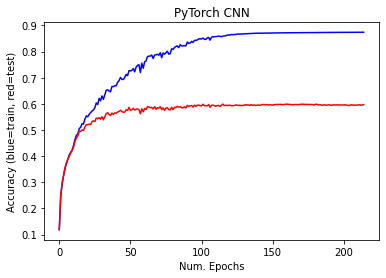

In [ ]:
train_x, train_y, test_x, test_y = getData()
print("Loaded data successfully.")
train_data = [(np.reshape(train_x[i], (3,32,32)).get(),torch.from_numpy(train_y[i].get()).to('cuda:0')) for i in range(len(train_x))]
test_data = [(np.reshape(test_x[i], (3,32,32)).get(),torch.from_numpy(test_y[i].get()).to('cuda:0')) for i in range(len(test_x))]

training_loader = torch.utils.data.DataLoader(train_data, batch_size=500, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=500, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()
model = CNN(conv1_out_channels=20, conv1_kernel=(5,5),
                 conv2_out_channels=20, conv2_kernel=(10,10))
model.to(torch.device('cuda:0'))
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

def train_one_epoch(epoch_i):
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    test_acc = torch_evaluate_acc(test_loader, model)
    train_acc = torch_evaluate_acc(training_loader, model)
    print("epoch", epoch_i, "completed. Train accuracy:", train_acc, ". Test accuracy:", test_acc)
    return test_acc, train_acc

train_accuracy_per_epoch = []
test_accuracy_per_epoch = []
epoch_num = 0
last_test_acc_increase = 0
best_test_acc = 0
while epoch_num - last_test_acc_increase < 100:
    test_acc, train_acc = train_one_epoch(epoch_num)
    test_accuracy_per_epoch.append(test_acc)
    train_accuracy_per_epoch.append(train_acc)
    if test_acc > best_test_acc: last_test_acc_increase = epoch_num
    best_test_acc = max(test_acc, best_test_acc)
    epoch_num += 1

print("Max test accuracy is", best_test_acc)

plt.figure(0)
plt.plot(train_accuracy_per_epoch, color="blue")
plt.plot(test_accuracy_per_epoch, color="red")
plt.title("PyTorch CNN")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

EXPERIMENT 6 - ResNet Training

In [ ]:
train_x, train_y, test_x, test_y = getData()
print("Loaded data successfully.")
train_data = [(np.reshape(train_x[i], (3,32,32)).get(),torch.from_numpy(train_y[i].get()).to('cuda:0')) for i in range(len(train_x))]
test_data = [(np.reshape(test_x[i], (3,32,32)).get(),torch.from_numpy(test_y[i].get()).to('cuda:0')) for i in range(len(test_x))]

training_loader = torch.utils.data.DataLoader(train_data, batch_size=500, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=500, shuffle=True)

fc =  nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
    nn.Softmax(dim=1))

model = CustomResnet18(fc)
model.to(torch.device('cuda:0'))
loss_fn = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

def train_one_epoch(epoch_i):
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    test_acc = torch_evaluate_acc(test_loader, model)
    train_acc = torch_evaluate_acc(training_loader, model)
    print("epoch", epoch_i, "completed. Train accuracy:", train_acc, ". Test accuracy:", test_acc)
    return test_acc, train_acc


train_accuracy_per_epoch = []
test_accuracy_per_epoch = []
epoch_num = 0
last_test_acc_increase = 0
best_test_acc = 0
while epoch_num - last_test_acc_increase < 100:
    test_acc, train_acc = train_one_epoch(epoch_num)
    test_accuracy_per_epoch.append(test_acc)
    train_accuracy_per_epoch.append(train_acc)
    if test_acc > best_test_acc: last_test_acc_increase = epoch_num
    best_test_acc = max(test_acc, best_test_acc)
    epoch_num += 1

print("Max test accuracy is", best_test_acc)

plt.figure(0)
plt.plot(train_accuracy_per_epoch, color="blue")
plt.plot(test_accuracy_per_epoch, color="red")
plt.title("Resnet18 Pre-Trained model with custom FC")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

EXPERIMENT 7 - Increasing depth of MLP

In [ ]:
train_x, train_y, test_x, test_y = getData()
print("Loaded data successfully.")

optimizer = GradientDescent(learning_rate=.1, batch_size=500, momentum=0.5)
model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=3, hidden_units=[256, 256, 256])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(0)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("3 Hidden Layers, with 256 units, ReLu activation")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=4, hidden_units=[256, 256, 256, 256])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(1)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("4 hidden Layers with 256 units, ReLu activation")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

EXPERIMENT 8 - Varying the width of MLP

In [ ]:
#Smaller width 
train_x, train_y, test_x, test_y = getData()
print("Loaded data successfully.")

optimizer = GradientDescent(learning_rate=.1, batch_size=500, momentum=0.5)
model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=2, hidden_units=[150, 150])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(0)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("2 Hidden Layers, with 150 units, ReLu activation")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=2, hidden_units=[100, 100])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(1)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("2 hidden Layers with 100 units, ReLu activation")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

#Bigger width 
train_x, train_y, test_x, test_y = getData()
print("Loaded data successfully.")

optimizer = GradientDescent(learning_rate=.1, batch_size=500, momentum=0.5)
model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=2, hidden_units=[500, 500])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(0)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("2 Hidden Layers, with 500 units, ReLu activation")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=2, hidden_units=[700, 700])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(1)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("2 hidden Layers with 700 units, ReLu activation")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()

EXPERIMENT 9 - Incresed width and depth MLP

In [ ]:
train_x, train_y, test_x, test_y = getData()
print("Loaded data successfully.")

optimizer = GradientDescent(learning_rate=.1, batch_size=500, momentum=0.5)
model = MLP(activation=relu, activation_gradient=relu_gradient, hidden_layers=3, hidden_units=[500, 500, 500])
model.fit(train_x, train_y, optimizer, test_x, test_y)

plt.figure(0)
plt.plot(optimizer.train_accuracy_per_epoch, color="blue")
plt.plot(optimizer.test_accuracy_per_epoch, color="red")
plt.title("2 Hidden Layers, with 150 units, ReLu activation")
plt.xlabel('Num. Epochs')
plt.ylabel('Accuracy (blue=train, red=test)')
plt.show()